# Problem statement:
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Motivation**: To create a multiclass classification model using a custom convolutional neural network in tensorflow

**Data Summary:**

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:
1. Actinic keratosis
2. Basal cell carcinoma
3. Dermatofibroma
4. Melanoma
5. Nevus
6. Pigmented benign keratosis
7. Seborrheic keratosis
8. Squamous cell carcinoma
9. Vascular lesion


### Importing Skin Cancer Data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow.keras.layers import (
    Rescaling,
    Conv2D,
    MaxPooling2D,      # <-- note: it's MaxPooling2D, not MaxPool2D
    BatchNormalization,
    Flatten,
    Dense,
    Activation,
    Dropout,
)
# from tensorflow import keras
# from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
# from tensorflow.keras.layers import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
import pathlib
root_path = '/content/drive/MyDrive/MSDS/CNN_assignment/Skin Cancer ISIC Images'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')
print(data_dir_train)
print(data_dir_test)

/content/drive/MyDrive/MSDS/CNN_assignment/Skin Cancer ISIC Images/Train
/content/drive/MyDrive/MSDS/CNN_assignment/Skin Cancer ISIC Images/Test


In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:

batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
## Write your test dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

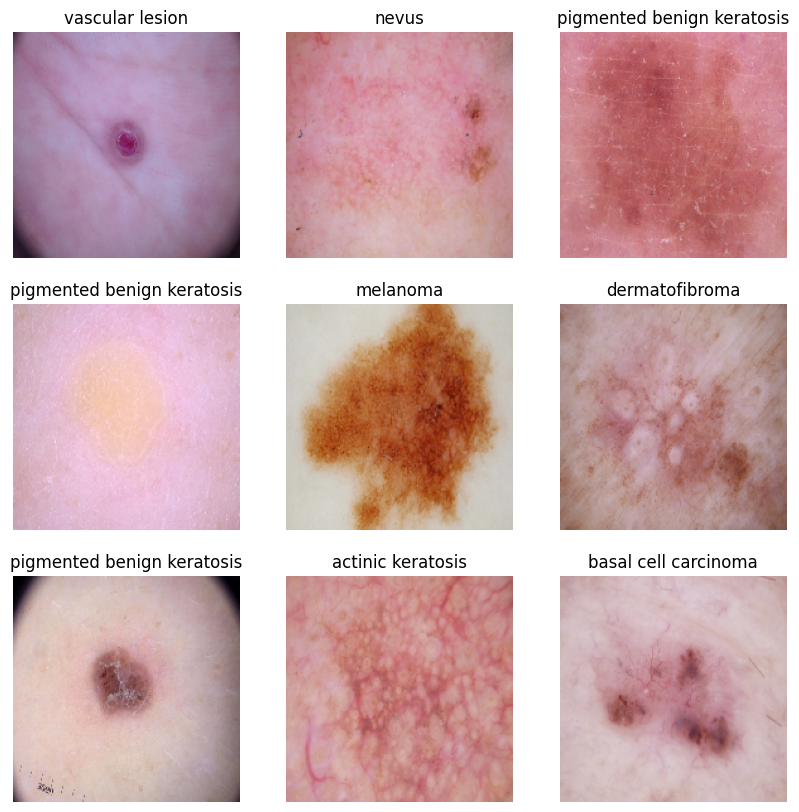

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
preprocessing_layers = [
    tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3))
]
# preprocessing_layers = [
#     # First, declare an explicit Input layer:
#     tf.keras.layers.Input(shape=(180, 180, 3)),
#
#     # Then your Rescaling (no input_shape needed here):
#     tf.keras.layers.Rescaling(1./255),
# ]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
### Your code goes here
# Hyper‑parameters (feel free to tweak)
input_shape = (180, 180, 3)
num_classes = 9          # <-- change this if you have a different number of classes
learning_rate = 1e-5

train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
val_ds   = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))

model = Sequential([
    Rescaling(1./255, input_shape=input_shape),

    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.5),

    # Final classification layer
    Dense(num_classes, activation='softmax')
])

# Compile the model (you can adjust the optimiser / loss)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',   # or 'sparse_categorical_crossentropy' if your labels are ints
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 180, 180, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    31,719,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,827,817 (121.41 MB)

 Trainable params: 31,827,433 (121.41 MB)

 Non-trainable params: 384 (1.50 KB)

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [14]:
### Todo, choose an appropirate optimiser and loss function

optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 180, 180, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    31,719,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,827,817 (121.41 MB)

 Trainable params: 31,827,433 (121.41 MB)

 Non-trainable params: 384 (1.50 KB)

### Train the model

In [16]:
print(train_ds.element_spec)

(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))


In [17]:
print(model.output_shape)

(None, 9)


In [18]:
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 506s 2s/step - accuracy: 0.2307 - loss: 2.9122 - val_accuracy: 0.1253 - val_loss: 1.1347
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.2052 - loss: 0.4150 - val_accuracy: 0.0515 - val_loss: 2.4073
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.2273 - loss: 0.3929 - val_accuracy: 0.1521 - val_loss: 2.8302
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.2592 - loss: 0.3705 - val_accuracy: 0.0917 - val_loss: 2.4393
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.2848 - loss: 0.3563 - val_accuracy: 0.1432 - val_loss: 1.5006
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.3281 - loss: 0.3518 - val_accuracy: 0.1454 - val_loss: 1.2915
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.2846 - loss: 0.3532 - val_accuracy: 0.2237 - val_loss: 0.3746
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.3209 - loss: 0.3418 - val_accuracy: 0.2886 - v

### Visualizing training results

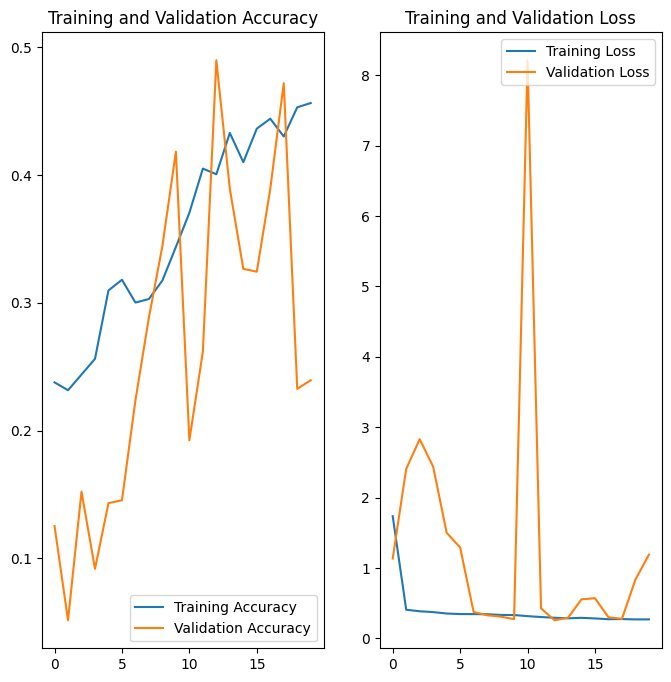

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Model Overfit or Underfit?

In [20]:

loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


# Thus we can clearly that model Overfit and we need to chose right data augumentation strategy

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2249 - loss: 1.2224
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2597 - loss: 1.1403
Accuracy:  0.2299107164144516
Validation Accuracy:  0.2393735945224762
Loss:  1.1825850009918213
Validation Loss 1.1895984411239624


In [21]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)


Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


In [22]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [23]:
labels.shape

TensorShape([32])

In [24]:
batch_size

32

In [25]:
train_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

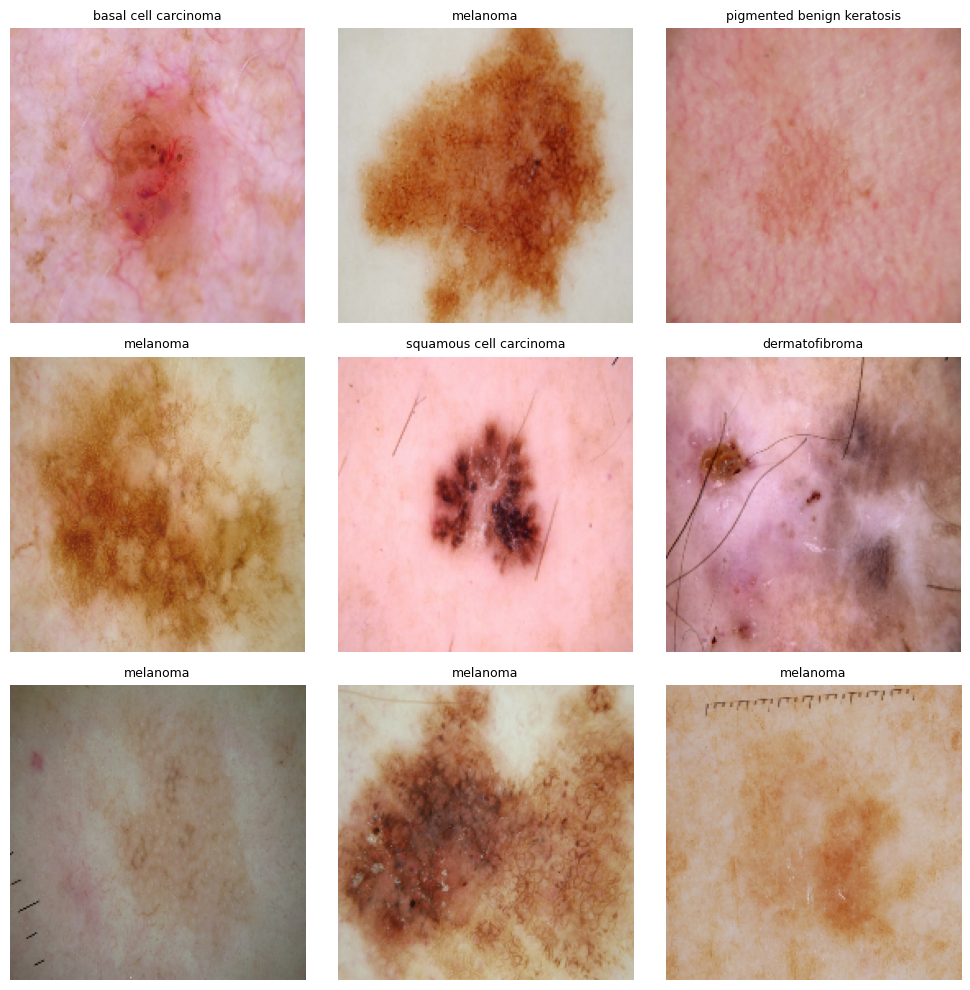

In [26]:
# visualize how your augmentation strategy works for one instance of training image.

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):          # batch of 32 images + (32,9) binary vectors
    labels_np = labels.numpy()                  # shape (32, 9)

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        ax.imshow(images[i].numpy().astype("uint8"))

        # Find all indices where the label is 1
        active_idxs = np.where(labels_np[i] > 0.5)[0]
        if len(active_idxs) == 0:
            title_str = "No class"
        else:
            title_str = ", ".join([class_names[j] for j in active_idxs])

        ax.set_title(title_str, fontsize=9)
        ax.axis("off")

plt.tight_layout()
plt.show()


### Create the model, compile and train the model


In [27]:
## You can use Dropout layer if there is an evidence of overfitting in your findings


model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(MaxPooling2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 180, 180, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 90, 90, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 43, 43, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 56448)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    28,901,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,045,929 (110.80 MB)

 Trainable params: 29,045,929 (110.80 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling the model

In [28]:
# optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
#
# model.compile(loss='categorical_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

In [29]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)

### Training the model

In [30]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
batch_size = 10

history = model.fit(train_batches,
  epochs = epochs, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - accuracy: 0.3649 - loss: 359.4311 - val_accuracy: 0.3333 - val_loss: 1.1809 - learning_rate: 0.0010
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.4013 - loss: 2.9311 - val_accuracy: 0.3750 - val_loss: 1.8518 - learning_rate: 0.0010
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.4511 - loss: 1.0841 - val_accuracy: 0.3542 - val_loss: 1.6819 - learning_rate: 0.0010
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.4811 - loss: 1.0009 - val_accuracy: 0.3542 - val_loss: 1.5720 - learning_rate: 0.0010
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5323 - loss: 0.9522
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5315 - loss: 0.9525 - val_accuracy: 0.3750 - val_loss: 1.5218 - learning_rate: 0.0010
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5219 - loss: 0.9329 - val_accuracy: 

### Visualizing the results

<built-in method keys of dict object at 0x7b63d05aaf00> :


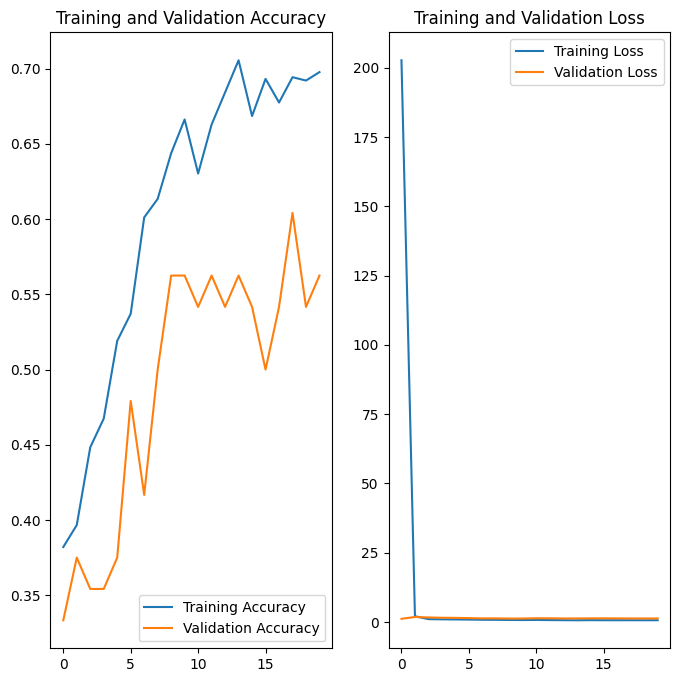

In [31]:
acc = history.history['accuracy']
print(history.history.keys, ":")
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1201 - loss: 3.5203
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.0651 - loss: 3.9126
Accuracy:  0.1171875
Validation Accuracy:  0.08724832534790039
Loss:  3.522618055343628
Validation Loss 3.755791187286377


#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Batch - Labels shape: (32, 9), Images shape: (32, 180, 180, 3)


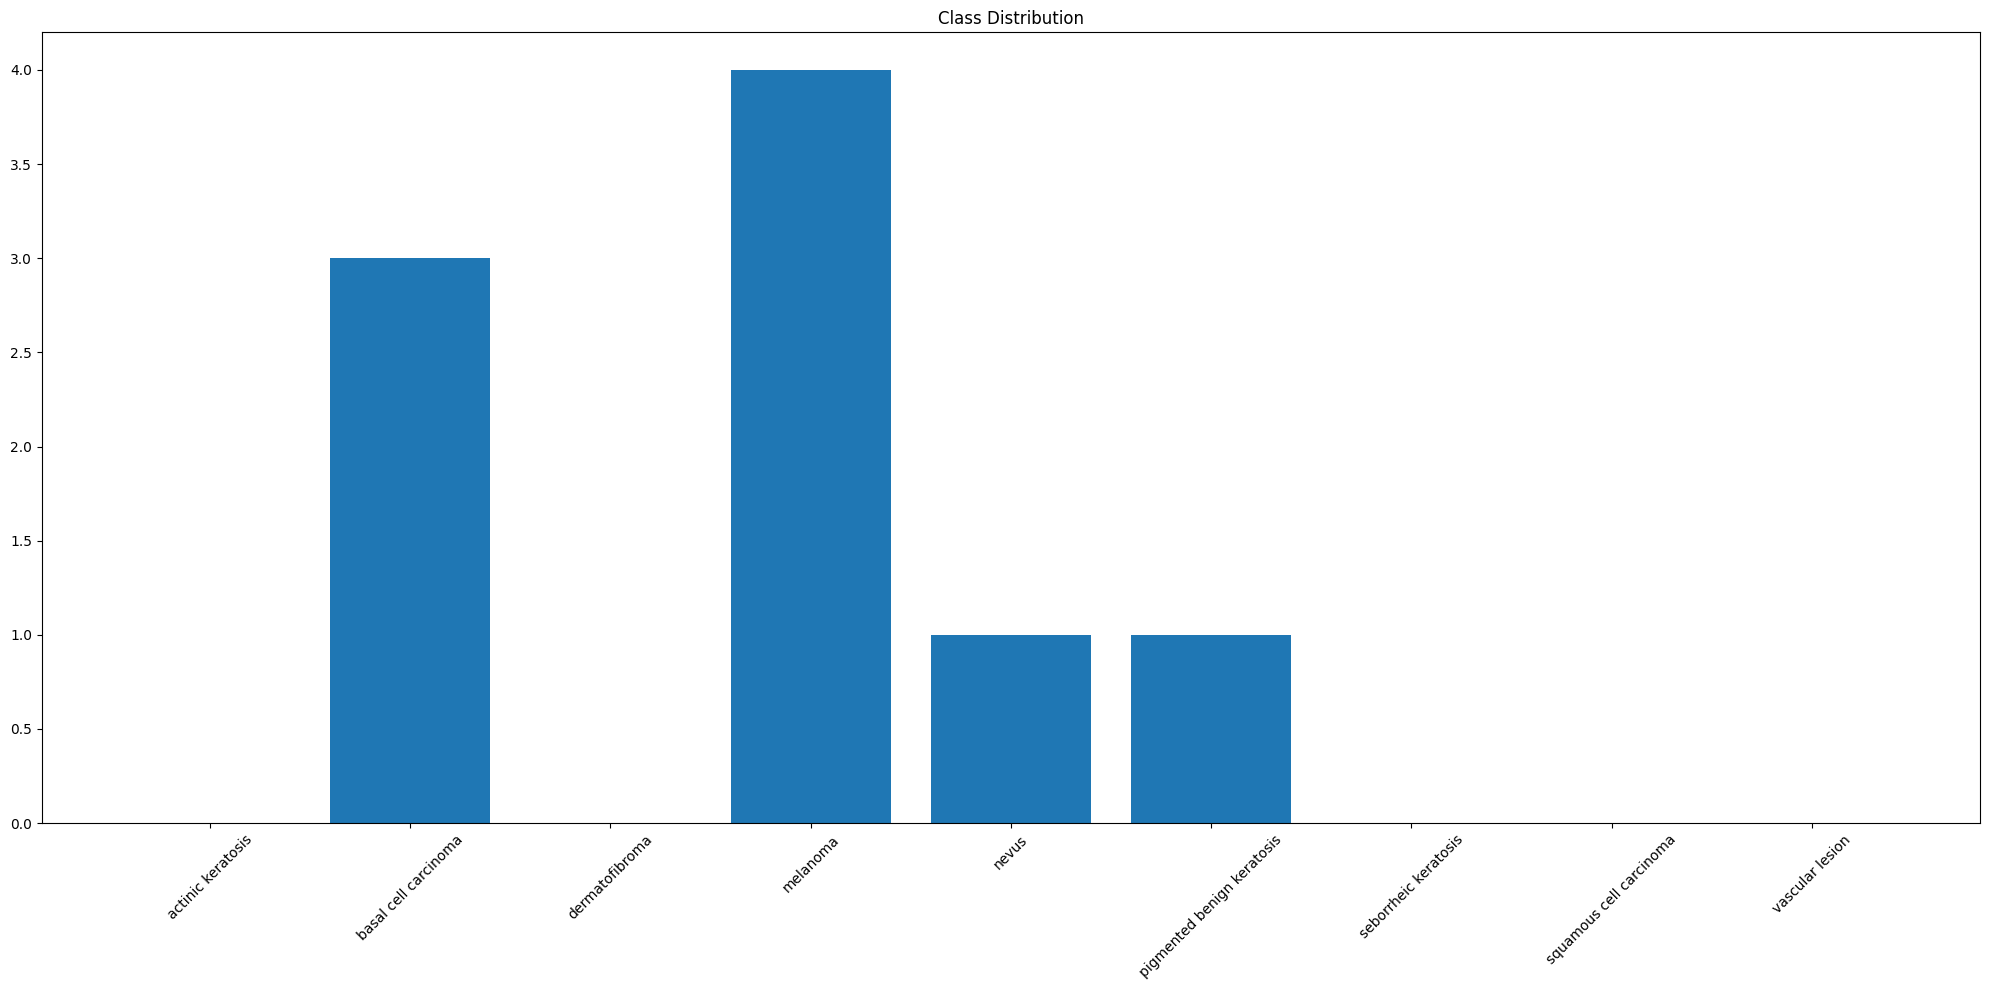

actinic keratosis: 0
basal cell carcinoma: 3
dermatofibroma: 0
melanoma: 4
nevus: 1
pigmented benign keratosis: 1
seborrheic keratosis: 0
squamous cell carcinoma: 0
vascular lesion: 0


In [33]:
# data = dict()
#
# for i in class_names:
#   data[i] = []
#
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds:
#   for i in range(9):
#     data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))
#
# for i in data:
#   data[i] = len(data[i])
#
# f = plt.figure()
# f.set_figwidth(20)
# f.set_figheight(20)
#
# plt.bar(range(len(data)), list(data.values()), align='center')
# plt.xticks(range(len(data)), list(data.keys()))
# plt.show()

import numpy as np
import matplotlib.pyplot as plt

data = dict()

for i in class_names:
    data[i] = []

for images, labels in train_ds:
    # Convert to numpy
    labels_np = labels.numpy()
    images_np = images.numpy()

    # Debug prints (remove after fixing)
    print(f"Batch - Labels shape: {labels_np.shape}, Images shape: {images_np.shape}")

    batch_size = min(9, labels_np.shape[0])

    for i in range(batch_size):
        try:
            # Get label for this sample
            label_data = labels_np[i]

            # Handle different label formats
            if isinstance(label_data, (np.ndarray, list)) and len(label_data) > 1:
                # One-hot encoded
                class_idx = np.argmax(label_data)
            else:
                # Integer label
                class_idx = int(label_data)

            # Ensure class_idx is valid
            if 0 <= class_idx < len(class_names):
                data[class_names[class_idx]].append(images_np[i].astype("uint8"))
            else:
                print(f"Invalid class index: {class_idx}")

        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            print(f"Label data: {label_data}")
            continue

    break  # Process only first batch for debugging

# Convert to counts
for i in data:
    data[i] = len(data[i])

# Plot
f = plt.figure(figsize=(20, 10))
plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()), rotation=45)
plt.title("Class Distribution")
plt.tight_layout()
plt.show()

# Print results
for class_name, count in data.items():
    print(f"{class_name}: {count}")

#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.


#### - Which class has the least number of samples? - **Actinic Keratosos** and **Seborrheic keratosis**
#### - Which classes dominate the data in terms proportionate number of samples?
**Pigmented benign keratosis** dominates the data of count more than 100 in training


In [38]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [39]:
data_dir_train

PosixPath('/content/drive/MyDrive/MSDS/CNN_assignment/Skin Cancer ISIC Images/Train')

In [40]:
path_to_training_dataset=data_dir_train
# data_dir_train = pathlib.Path(root_path + '/Train')
import Augmentor
for i in class_names:
    # Use / operator for path joining with pathlib
    class_path = path_to_training_dataset / i
    p = Augmentor.Pipeline(str(class_path))  # Convert to string for Augmentor
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)


Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/MSDS/CNN_assignment/Skin Cancer ISIC Images/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B63E974D580>: 100%|██████████| 500/500 [00:17<00:00, 27.94 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/MSDS/CNN_assignment/Skin Cancer ISIC Images/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B64673513D0>: 100%|██████████| 500/500 [00:17<00:00, 28.52 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/MSDS/CNN_assignment/Skin Cancer ISIC Images/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B63E95A0800>: 100%|██████████| 500/500 [00:17<00:00, 29.28 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/MSDS/CNN_assignment/Skin Cancer ISIC Images/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7B63C11BD5B0>: 100%|██████████| 500/500 [01:24<00:00,  5.94 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/MSDS/CNN_assignment/Skin Cancer ISIC Images/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7B63C12813D0>: 100%|██████████| 500/500 [01:18<00:00,  6.33 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/MSDS/CNN_assignment/Skin Cancer ISIC Images/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B63D06B46E0>: 100%|██████████| 500/500 [00:20<00:00, 24.98 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/MSDS/CNN_assignment/Skin Cancer ISIC Images/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B63D0369550>: 100%|██████████| 500/500 [00:40<00:00, 12.25 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/MSDS/CNN_assignment/Skin Cancer ISIC Images/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B63D0364A70>: 100%|██████████| 500/500 [00:16<00:00, 30.94 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/MSDS/CNN_assignment/Skin Cancer ISIC Images/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B63D05111F0>: 100%|██████████| 500/500 [00:17<00:00, 29.37 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [41]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [42]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/MSDS/CNN_assignment/Skin Cancer ISIC Images/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010971.jpg_5f5910f8-f678-4739-a24c-0883c893418f.jpg',
 '/content/drive/MyDrive/MSDS/CNN_assignment/Skin Cancer ISIC Images/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011039.jpg_7ce1c606-97aa-4cea-9e4f-595786800397.jpg',
 '/content/drive/MyDrive/MSDS/CNN_assignment/Skin Cancer ISIC Images/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011161.jpg_8a459002-eea5-4eee-9192-62051b9f9c38.jpg',
 '/content/drive/MyDrive/MSDS/CNN_assignment/Skin Cancer ISIC Images/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010979.jpg_ad179033-f15e-4374-b867-df695d95a174.jpg',
 '/content/drive/MyDrive/MSDS/CNN_assignment/Skin Cancer ISIC Images/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011135.jpg_7e310e12-8570-4885-9acb-e48368dc4245.jpg',
 '/content/drive/MyDrive/MSDS/CNN_a

In [43]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [44]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [45]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [46]:
new_df['Label'].value_counts()

,count
Label,
seborrheic keratosis,500
nevus,500
squamous cell carcinoma,500
dermatofibroma,500
actinic keratosis,500
basal cell carcinoma,500
pigmented benign keratosis,500
vascular lesion,500
melanoma,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [47]:
batch_size = 32
img_height = 180
img_width = 180

In [48]:
input_shape = (img_height, img_width, 3)  # 3 for RGB channels

#### Create a training dataset

In [49]:
data_dir_train = "/content/drive/MyDrive/MSDS/CNN_assignment/Skin Cancer ISIC Images/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir_train,
        seed=123,
        validation_split=0.2,
        subset='training',
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='int'  # Explicitly specify integer labels
    )

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [50]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir_train,
        seed=123,
        validation_split=0.2,
        subset='validation',
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='int'  # Explicitly specify integer labels
    )

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [51]:
# Check number of classes to determine if it's binary or multi-class
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Number of classes: 9
Class names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#### Create your model (make sure to include normalization)

In [52]:
# Configure datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [53]:
#### Create your model
model = Sequential([
    # Add normalization layer to handle pixel values (0-255) -> (0-1)
    Rescaling(1./255, input_shape=input_shape),

    # First block
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.25),

    # Second block
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.4),

    # Third block
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # Classification layers
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output layer - automatically configured based on number of classes
    Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')
])

model.summary()

#### Compile the model
# Choose loss function based on number of classes
if num_classes == 2:
    loss_function = 'binary_crossentropy'
    metrics = ['accuracy']
else:
    loss_function = 'sparse_categorical_crossentropy'  # For integer labels
    metrics = ['accuracy']

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 180, 180, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 90, 90, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,071,977 (30.79 MB)

 Trainable params: 8,071,273 (30.79 MB)

 Non-trainable params: 704 (2.75 KB)

#### Compile your model (Choose optimizer and loss function appropriately)

In [54]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False)

model.compile(
    loss=loss_function,
    optimizer=optimizer,
    metrics=metrics
)

print(f"Model compiled with loss function: {loss_function}")

Model compiled with loss function: sparse_categorical_crossentropy


####  Train your model

In [55]:
epochs = 50

# Callbacks
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
        train_ds,
        epochs=epochs,
        verbose=1,
        validation_data=val_ds,
        callbacks=[learning_rate_reduction, early_stopping]
    )

print("Training completed successfully!")

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 78s 191ms/step - accuracy: 0.2698 - loss: 2.3845 - val_accuracy: 0.1151 - val_loss: 5.2446 - learning_rate: 0.0010
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.4289 - loss: 1.6197 - val_accuracy: 0.1492 - val_loss: 3.8045 - learning_rate: 0.0010
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.4937 - loss: 1.4076 - val_accuracy: 0.3296 - val_loss: 1.8245 - learning_rate: 0.0010
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.5510 - loss: 1.2443 - val_accuracy: 0.2739 - val_loss: 3.9625 - learning_rate: 0.0010
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.6110 - loss: 1.1047 - val_accuracy: 0.6154 - val_loss: 1.0312 - learning_rate: 0.0010
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.6501 - loss: 0.9759 - val_accuracy: 0.5709 - val_loss: 1.2015 - learning_rate: 0.0010
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.6713 - 

####  Visualize the model results

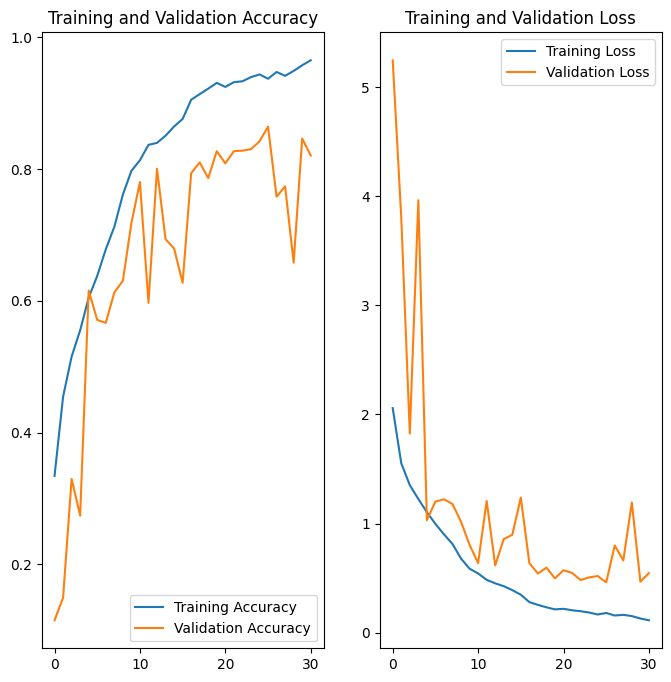

In [56]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
#
# loss = history.history['loss']
# val_loss = history.history['val_loss']
#
# epochs_range = range(epochs)
#
# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')
#
# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Fix: Create epochs_range based on actual length of training data
epochs_range = range(len(acc))  # or range(len(loss)) - they should be the same

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Did you get rid of underfitting/overfitting? Did class rebalance help?



The class rebalance helped in reducing overfititng of the data and thus the loass is beng reduced
But it reduced the Acurracy very low


Initially we tried without the ImageDataGenerator which created data to over fit at high ratio

Then we introduced dropout and ImageDataGenerator which reduced the over fit

At last we tried Batch Normalization and Augumentation which really helped in carry forward